In [2]:
import importlib
import sys, time

try:
    importlib.reload(sys.modules['DMlensing'])
    from DMlensing import *
except:
    from DMlensing import *

## Ray
import ray
ray.shutdown()
ray.init(num_cpus=12, ignore_reinit_error=True)

2023-06-23 08:47:48,831	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.10
Ray version:,2.3.1
Dashboard:,http://127.0.0.1:8265


In [4]:
# Set simulation environments
test_num = 1000     # total number of simulations
dat_num = 300       # n     {(t1, x1), ... (tn, xn)}
k_num = 100         # N_k   {k1, k2, ... k_Nk}, {phi1, ... phi_Nk}
ob_time = ly        # Total observation time for each detection (1 year)  
theta_ = 2*pi*ob_time/ly    # Detectors moves along the Earth orbit
noise = 1e-2        # Detector noise sigma.
# print(f"theta: ", theta_)

t_data = np.linspace(0,ob_time,dat_num) 
theta_data = np.linspace(0, theta_, dat_num) 
x_data = (AU/c)*np.array( [[cos(theta), cos(pi/3)*sin(theta), sin(pi/3)*sin(theta)] for theta in theta_data])


## Without lensing, only no lens case

data, covariance matrix are set.
elapse time: 0.7
test_num = 990 / 1000,	elapsed time:2.7

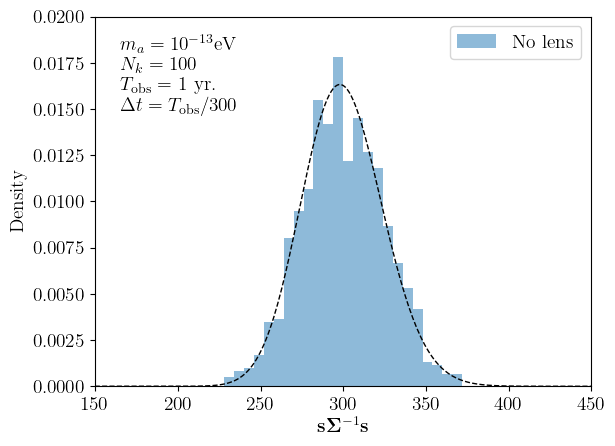


Done


In [5]:
#########################  Test simulation #######################
timestamp = time.time()

result_list = np.zeros(test_num)

data = DMRandomGenerator(t_data, x_data, k_num=k_num, seed=None)
test = stochasticDM(data=data, mpmath=False)

print(f"data, covariance matrix are set.\nelapse time: {time.time()-timestamp:.1f}")

for i in range(test_num):
    data = DMRandomGenerator(t_data, x_data, k_num=k_num, NO_LENSING=True, INCLUDE_LENSING=False, seed = i*4152)
    test.data = data

    result_list[i] = test.Log_likelihood(lensed=False)
    if i%10==0: print(f"\rtest_num = {i} / {test_num},\telapsed time:{time.time()-timestamp:.1f}", end='')

########################## Plot #####################3############

start = 150
end = 450

fig, ax = plt.subplots()

ax.hist(result_list, range=[start, end], bins=50, density=True, alpha=.5, label="No lens")

x_list = np.linspace(0,2*dat_num, 501)
ax.plot(x_list , chi2.pdf(x_list, df=dat_num), linestyle='--', linewidth=1, color='k')
ax.set_xlim(start, end)
ax.set_ylim(0,0.02)
ax.set_xlabel("$\\mathbf{s}\\mathbf{\\Sigma}^{-1}\\mathbf{s}$")
ax.set_ylabel("Density")
ax.legend()
ax.text( ax.get_xlim()[1]*0.05 + ax.get_xlim()[0]*0.95,
        ax.get_ylim()[1]*0.95,
        "$m_a = 10^{-13}$eV\n\
            $N_k=100$\n\
            $T_{\\rm obs} =$ 1 yr.\n\
            $\\Delta t = T_{\\rm obs}/300$",
        verticalalignment='top', horizontalalignment='left')
plt.show()
# plt.savefig(f'result/signal.jpg', dpi=600, bbox_inches='tight')
print("\nDone")
# #####################################################################

## Comparing with / without lensing

* The computation time for amplification is very large.
(For the given simulation setting, the total calculation time > 10 min. in my computer.)
* In this code, setting $\Delta t \ll T_{\rm coh}$ does not give proper results. Since det $(\Sigma)$ is extremely small, its inverse matrix can not be calculated correctly.

data, cov mat set. elapse time: 0.6
test_num = 990 / 1000,	elapsed time:657.4
Done


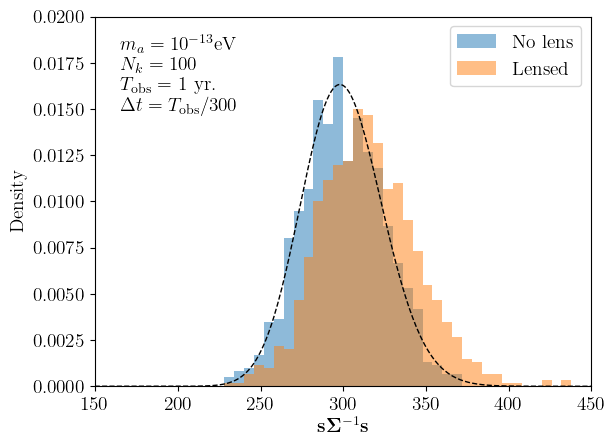

In [2]:
#########################  Test simulation #######################
timestamp = time.time()

result_list = np.zeros(test_num)
result_lensing_list=np.zeros(test_num)

data = DMRandomGenerator(t_data, x_data, k_num=k_num, seed=None)
test = stochasticDM(data=data, mpmath=False)

print(f"data, covariance matrix are set.\nelapse time: {time.time()-timestamp:.1f}")

for i in range(test_num):
    data = DMRandomGenerator(t_data, x_data, k_num=k_num, NO_LENSING=True, INCLUDE_LENSING=True, seed = i*4152)
    test.data = data

    result_list[i] = test.Log_likelihood(lensed=False)
    result_lensing_list[i] = test.Log_likelihood(lensed=True)
    if i%10==0: print(f"\rtest_num = {i} / {test_num},\telapsed time:{time.time()-timestamp:.1f}", end='')

########################## Plot #####################3############

start = 150
end = 450

fig, ax = plt.subplots()

ax.hist(result_list, range=[start, end], bins=50, density=True, alpha=.5, label="No lens")
ax.hist(result_lensing_list, range=[start, end], bins=50, density=True, alpha=.5, label="Lensed")

x_list = np.linspace(0,2*dat_num, 501)
ax.plot(x_list , chi2.pdf(x_list, df=dat_num), linestyle='--', linewidth=1, color='k')
ax.set_xlim(start, end)
ax.set_ylim(0,0.02)
ax.set_xlabel("$\\mathbf{s}\\mathbf{\\Sigma}^{-1}\\mathbf{s}$")
ax.set_ylabel("Density")
ax.legend()
ax.text( ax.get_xlim()[1]*0.05 + ax.get_xlim()[0]*0.95,
        ax.get_ylim()[1]*0.95,
        "$m_a = 10^{-13}$eV\n\
            $N_k=100$\n\
            $T_{\\rm obs} =$ 1 yr.\n\
            $\\Delta t = T_{\\rm obs}/300$",
        verticalalignment='top', horizontalalignment='left')
# plt.show()
plt.savefig(f'result/signal.jpg', dpi=600, bbox_inches='tight')
print("\nDone")
# #####################################################################

# Notepad

idx: 1001it [00:00, 1402.53it/s]


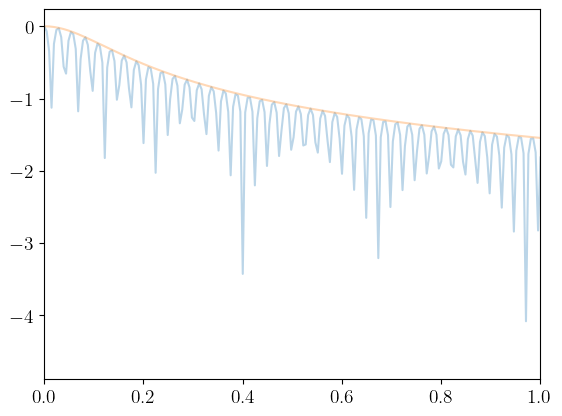

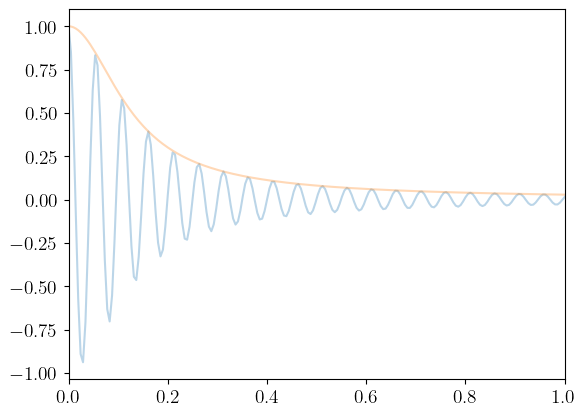

In [574]:
logt_data = np.linspace(0, 0.02*ly, 1001)#np.linspace(-8, 2, 1001)
t_data = logt_data# 10**logt_data * ly

# x_data = (AU/c)*np.array( [[cos(theta), cos(pi/3)*sin(theta), sin(pi/3)*sin(theta)] for theta in theta_data])
cov_data = np.zeros_like(t_data)
cov_data_zerodx = np.zeros_like(t_data)
cov_data_env = np.zeros_like(t_data)
cov_data_zerodx_env = np.zeros_like(t_data)

v_ob_vec = np.array( [0,0,8e-4] )
m=1e-13*eV/hbar
sig_v = 8e-4 / sqrt(2)
T_coh = 2*pi/(m*sig_v**2)

from tqdm import tqdm
for idx, dt in tqdm(enumerate(t_data), desc='idx'):
    theta = 2*pi*dt/ly
    dx_vec = (AU/c)* np.array( [cos(theta) - 1, cos(pi/3)*sin(theta), sin(pi/3)*sin(theta)] )
    cov_data[idx] = Cov_mat_component(dt, dx_vec, v_ob_vec, m, sig_v, envelop=False )
    cov_data_zerodx[idx] = Cov_mat_component(0, dx_vec, v_ob_vec, m, sig_v, envelop=False )
    cov_data_env[idx] = Cov_mat_component(dt, dx_vec, v_ob_vec, m, sig_v, envelop=True )
    cov_data_zerodx_env[idx] = Cov_mat_component(0, dx_vec, v_ob_vec, m, sig_v, envelop=True )

plt.plot(logt_data/T_coh , np.log10(abs(cov_data)), alpha=.3)
plt.plot(logt_data/T_coh , np.log10(abs(cov_data_env)), alpha=.3)
# plt.plot(logt_data/T_coh , np.log10(abs(cov_data_zerodx)), alpha=.3)
plt.xlim(0,1)
plt.show()

plt.plot(logt_data/T_coh , (cov_data), alpha=.3)
plt.plot(logt_data/T_coh , (cov_data_env), alpha=.3)

# plt.plot(logt_data/T_coh , cov_data_zerodx, alpha=.3)
plt.xlim(0,1)
plt.show()


### Complex analysis 를 시도해봤지만 실패

idx: 1001it [00:00, 2809.82it/s]


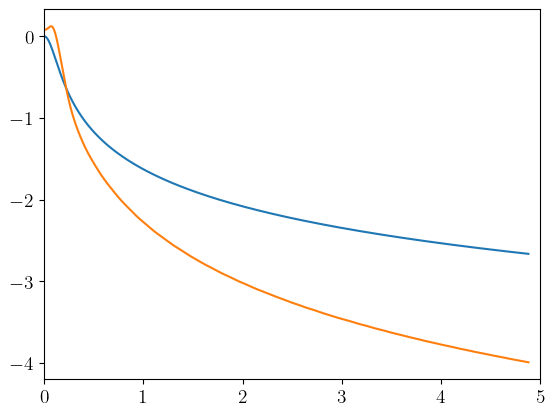

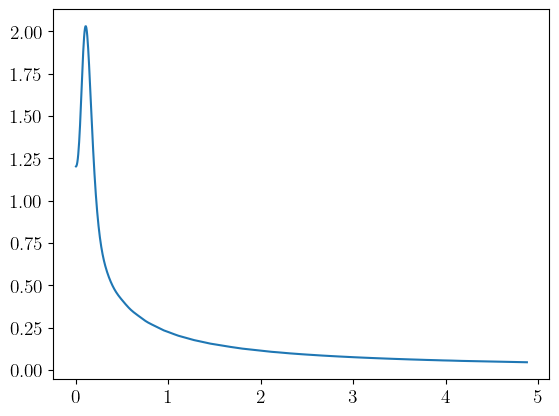

In [53]:
logt_data = np.linspace(0, 0.02*ly, 1001)#np.linspace(-8, 2, 1001)
t_data = logt_data  # 10**logt_data * ly

# x_data = (AU/c)*np.array( [[cos(theta), cos(pi/3)*sin(theta), sin(pi/3)*sin(theta)] for theta in theta_data])
cov_data = np.zeros_like(t_data)
cov_lens_data = np.zeros_like(t_data)
cov_data_env = np.zeros_like(t_data)
cov_lens_data_env = np.zeros_like(t_data)
amp_list = np.zeros_like(t_data)

v_ob_vec = np.array( [0,0,8e-4] )
m=1e-13*eV/hbar
sig_v = 8e-4 / sqrt(2)
T_coh = 2*pi/(m*sig_v**2)
tilt = pi/3

from tqdm import tqdm
for idx, dt in tqdm(enumerate(t_data), desc='idx'):
    theta0 = 0
    d_theta = 0#2*pi*dt/ly 
    theta = theta0 + d_theta

    x0_vec = (AU/c)* np.array( [sin(theta0), cos(tilt)*cos(theta0), sin(tilt)*cos(theta0)] )
    x_vec = (AU/c)* np.array( [sin(theta), cos(tilt)*cos(theta), sin(tilt)*cos(theta)] )
    dx_vec = x_vec - x0_vec
    
    # cov_data_zerodx[idx] = Cov_mat_component(0, dx_vec, v_ob_vec, m, sig_v, envelop=False )
    cov_comp = Cov_mat_component(dt, dx_vec, v_ob_vec, m, sig_v, complex=True )
    cov_data_env[idx] = abs(cov_comp)
    cov_data[idx] = cov_comp.real
    # cov_data_zerodx_env[idx] = Cov_mat_component(0, dx_vec, v_ob_vec, m, sig_v, envelop=True )

    zeta = 1 - 1j*m*sig_v**2*dt
    xi_vec = np.array(v_ob_vec, dtype=complex) - 1j*m*sig_v**2*np.array(dx_vec, dtype=complex)
    v_cplx_vec = xi_vec / zeta
    amp = np.conjugate(Amp_Sun(np.conjugate(v_cplx_vec), x0_vec)) * Amp_Sun(v_cplx_vec, x_vec)
    amp_list[idx] = abs(amp)

    cov_lens_data[idx] = (cov_comp*amp).real
    cov_lens_data_env[idx] = abs(cov_comp*amp)

# plt.plot(logt_data/T_coh , np.log10(abs(cov_data)), alpha=.3)
plt.plot(logt_data/T_coh , np.log10(abs(cov_data_env)), alpha=1)
# plt.plot(logt_data/T_coh , np.log10(abs(cov_lens_data)), alpha=.3)
plt.plot(logt_data/T_coh , np.log10(abs(cov_lens_data_env)), alpha=1)
# plt.plot(logt_data/T_coh , np.log10(abs(cov_data_zerodx)), alpha=.3)
plt.xlim(0,5)
plt.show()

plt.plot(logt_data/T_coh, (amp_list))
plt.show()

# plt.plot(logt_data/T_coh , (cov_data), alpha=.3)
# plt.plot(logt_data/T_coh , (cov_data_env), alpha=.3)

# # plt.plot(logt_data/T_coh , cov_data_zerodx, alpha=.3)
# plt.xlim(0,1)
# plt.show()

[ 1.  1. 16. 16.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


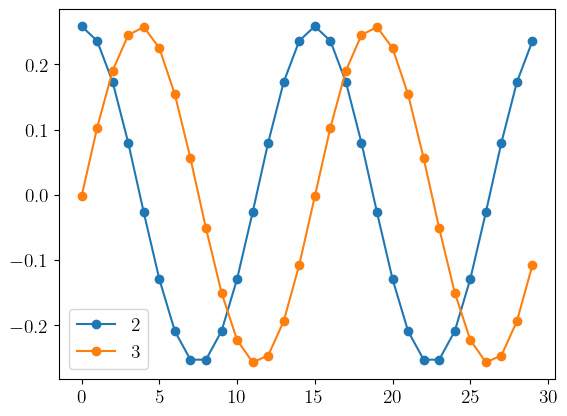

In [685]:
N = 30
w = 2*pi / N * 2
H = w*N
A = np.zeros((N,N))
noise = 1e-0

for i in range(N):
    for j in range(N):
        A[i,j] = cos(H/N*(i-j))
        if i==j:
            A[i,i] = A[i,i] + noise

evals, evecs = np.linalg.eig(A)
print(evals)
# print(evecs)

# np.linalg.eig(A)
for i in range(N):
    if abs(evals[i])>1+1e-12:
        # print(evecs[:,i])
        plt.plot(evecs[:,i], marker='o', label=i)
plt.legend()
plt.show()

# Changing the observation time

## |F| shape

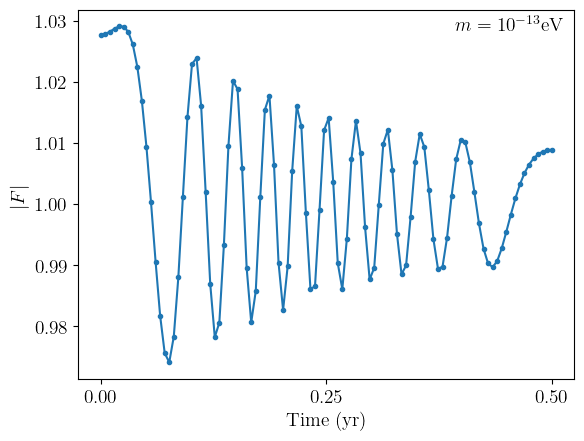

In [132]:
# Set simulation environments
dat_num = 100       # n     {(t1, x1), ... (tn, xn)}
ob_time = 0.5*ly        # Total observation time for each detection (1 year)  
theta_ = 2*pi*ob_time/ly    # Detectors moves along the Earth orbit
theta_offset = 0#0.1
# print(f"theta: ", theta_)
v0_vec = np.array([0,0,8e-4])
m=1e-13*eV/hbar
# m_list = np.array(-13, -12, -11, -14.5)

tilt = pi/6     # 0 -> 공전궤도면과 v_dm이 수직, pi/2 -> 공전궤도면과 v_dm이 나란   , pi/6 -> 현재 태양계

t_data = np.linspace(0,ob_time,dat_num) 
theta_data = np.linspace(0, theta_, dat_num) 
x_data = (AU/c)*np.array( [
    [sin(theta+theta_offset), cos(tilt)*cos(theta+theta_offset), sin(tilt)*cos(theta+theta_offset)]
      for theta in theta_data])

amp_data = np.zeros(dat_num, dtype=complex)

for i in range(dat_num):
    # print(Amp_Sun(v0_vec, x_data[i]))
    amp_data[i] = (Amp_Sun(v0_vec, x_data[i], m))

fig, ax = plt.subplots()
ax.plot(t_data/ly, abs(amp_data), marker='o', markersize=3)
ax.set_xticks([0,0.25,0.5])
ax.set_xlabel("Time (yr)")
ax.set_ylabel("$|F|$")

# optimal observation time?
# ax.axvline(x=0.0, linestyle='--', linewidth=1, color='k')
# ax.axvline(x=0.03, linestyle='--', linewidth=1, color='k')
# # ax.axvline(x=0.05, linestyle='--', linewidth=1, color='k')
# ax.axvline(x=0.075, linestyle='--', linewidth=1, color='k')
# ax.axvline(x=0.105, linestyle='--', linewidth=1, color='k')
# ax.axvline(x=0.125, linestyle='--', linewidth=1, color='k')

ax.text( ax.get_xlim()[1]*0.98 + ax.get_xlim()[0]*0.02,
         ax.get_ylim()[1]*0.98 + ax.get_ylim()[0]*0.02,
         f"$m=10^{{-13}}$eV",
         horizontalalignment='right', verticalalignment='top')
# plt.savefig("result/F_mag_001.png", bbox_inches='tight', dpi=200)
plt.show()

> The absolute value of amplification.  
> It seems that the optimal observation time is 0.05~0.1yr from the Spring (when the amplification becomes maximized).

## Test statistics

In [10]:
# simulation variables
tilt = pi/2 - pi/3
m = 1e-13*eV/hbar
sig_v = 8e-4/sqrt(2)

# system variables
seed = 2122
max_test_num = 30

# Set simulation environments
test_num = 100     # total number of simulations
bin_dat_num = 3000
bin_start_list = [0.0]#[0.0, 0.1, 0.2, 0.3, 0.4]
bin_num = len(bin_start_list)

dat_num = bin_dat_num * bin_num        # n     {(t1, x1), ... (tn, xn)}
k_num = 500         # N_k   {k1, k2, ... k_Nk}, {phi1, ... phi_Nk}
ob_time = 4*ly#(bin_dat_num-1)*(25/m)#2e-4*ly        # Total observation time for each detection (1 year)  
theta_ = 0#2*pi*ob_time/ly    # Detectors moves along the Earth orbit
theta_offset = 0
noise = 1e-2        # Detector noise sigma.
# print(f"theta: ", theta_)

################33########
bin_start_list = np.array(bin_start_list)*ly

t_data = np.concatenate( [np.linspace(bin_start, ob_time+bin_start, bin_dat_num) for bin_start in bin_start_list] )
theta_data = np.linspace(0, theta_, dat_num) 
x_data = (AU/c)*np.array( [
    [sin(theta+theta_offset-theta_/2), cos(tilt)*cos(theta+theta_offset-theta_/2), sin(tilt)*cos(theta+theta_offset-theta_/2)]
      for theta in theta_data] )

# Print
T_coh = 2*pi / (m*sig_v**2)
print(f"T_coh = {T_coh}")
print(f"Time space/T_coh = {ob_time/dat_num/T_coh}")
print(f"Time space/T_period = {ob_time/dat_num * m}")

restart=True

T_coh = 129238.26130862013
Time space/T_coh = 0.3253525664477151
Time space/T_period = 6388282.703617042


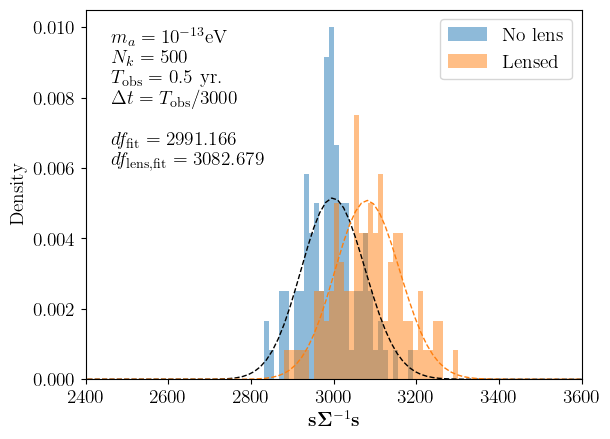


Done
 ###################### 
test_num = 100
dat_num  = 3000
k_num    = 500
ob_time/yr = 4.0
offset = 0
noise  = 0.01


In [12]:
#########################  Test simulation #######################
if restart:
    timestamp = time.time() ####

    result2_list = []#np.zeros(test_num)
    result2_lensing_list = []#np.zeros(test_num)

    test_count = test_num // max_test_num
    remain_test_num = test_num % max_test_num

    data2 = DMRandomGenerator(t_data, x_data, k_num=k_num, sig_v=sig_v, m=m, noise=noise, seed=None)
    test2 = stochasticDM(data=data2, mpmath=False)

    ########
    for k in range(test_count):

        data2 = DMRandomGenerator(t_data, x_data, k_num=k_num, sig_v=sig_v, m=m, noise=noise,
                                NO_LENSING=True, INCLUDE_LENSING=True, seed=seed, test_num=max_test_num)
        
        for i in range(max_test_num):
            # data2 = DMRandomGenerator(t_data, x_data, k_num=k_num, sig_v=sig_v, m=m, noise=noise, NO_LENSING=True, INCLUDE_LENSING=True, seed = i*2121)
            test2.data = data2[i]

            result2_list.append( test2.Log_likelihood(lensed=False) )
            result2_lensing_list.append( test2.Log_likelihood(lensed=True) )

        print(f"\r{(k+1)*max_test_num}/{test_num}", end='')

    ########
    if remain_test_num>0:
        data2 = DMRandomGenerator(t_data, x_data, k_num=k_num, sig_v=sig_v, m=m, noise=noise,
                            NO_LENSING=True, INCLUDE_LENSING=True, seed=seed, test_num=remain_test_num)
    
    for i in range(remain_test_num):
        # data2 = DMRandomGenerator(t_data, x_data, k_num=k_num, sig_v=sig_v, m=m, noise=noise, NO_LENSING=True, INCLUDE_LENSING=True, seed = i*2121)
        test2.data = data2[i]

        result2_list.append( test2.Log_likelihood(lensed=False) )
        result2_lensing_list.append( test2.Log_likelihood(lensed=True) )

    if remain_test_num>0: print(f"\r{test_num}/{test_num}")
    print(f"data, covariance matrix are set.\nelapse time: {time.time()-timestamp:.1f}")    ####

    result2_list = np.array(result2_list)
    result2_lensing_list = np.array(result2_lensing_list)

    ## fit
    df=dat_num
    df_n = chi2.fit(result2_list, floc=0, fscale=1)[0]
    df_l = chi2.fit(result2_lensing_list, floc=0, fscale=1)[0]
    mu_l, std_l = norm.fit(result2_lensing_list)

restart = False

########################## Plot #####################3############
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

start = dat_num*0.8
end = dat_num*1.2

fig, ax = plt.subplots()
no_lens_plot = ax.hist(result2_list, range=[start, end], bins=100, density=True, alpha=.5, label="No lens")
lens_plot    = ax.hist(result2_lensing_list, range=[start, end], bins=100, density=True, alpha=.5, label="Lensed")

x_list = np.linspace(0,2*end, 501)
ax.plot(x_list , chi2.pdf(x_list, df=dat_num), linestyle='--', linewidth=1, color='k')
ax.plot(x_list , chi2.pdf(x_list, df=df_l), linestyle='--', linewidth=1, color=colors[1])
# ax.plot(x_list , norm.pdf(x_list, df, sqrt(2*df)), linestyle='--', linewidth=1, color=colors[0])
# ax.plot(x_list , norm.pdf(x_list, mu_l, std_l), linestyle='--', linewidth=1, color=colors[1])
ax.set_xlim(start, end)
# ax.set_ylim(0,0.02)
ax.set_xlabel("$\\mathbf{s}\\mathbf{\\Sigma}^{-1}\\mathbf{s}$")
ax.set_ylabel("Density")
ax.legend()
ax.text( ax.get_xlim()[1]*0.05 + ax.get_xlim()[0]*0.95,
        ax.get_ylim()[1]*0.95,
        f"$m_a = 10^{{-13}}$eV\n\
            $N_k={k_num}$\n\
            $T_{{\\rm obs}} =$ 0.5 yr.\n\
            $\\Delta t = T_{{\\rm obs}}/{dat_num}$\n\n\
            $df_{{\\rm fit}}={df_n:.3f}$\n\
            $df_{{\\rm lens, fit}}={df_l:.3f}$",
        verticalalignment='top', horizontalalignment='left')
## result name
save = False
if save:
    from os import listdir
    from os.path import isfile, join
    from datetime import datetime

    exist_files = [f for f in listdir("./result") if isfile(join("./result", f))]
    file_num=0
    while True:
        file_name = "CompareLensing_" + datetime.utcnow().strftime('%Y%m%d') + f"_{file_num:03d}" + ".png"
        if not file_name in exist_files: break
        file_num += 1

    plt.savefig("result/"+file_name, dpi=600, bbox_inches='tight')

plt.show()
# plt.savefig(f'result/signal.jpg', dpi=600, bbox_inches='tight')
print("\nDone")
print(" ###################### ")
print(f"test_num = {test_num}")
print(f"dat_num  = {dat_num}")
print(f"k_num    = {k_num}")
print(f"ob_time/yr = {ob_time/ly}")
print(f"offset = {theta_offset}")
print(f"noise  = {noise}")
# #####################################################################

In [15]:
from scipy.stats import norm, chi2, ttest_1samp
df=dat_num
mu, std = norm.fit(result2_list)
mu_l, std_l = norm.fit(result2_lensing_list)
mu_fit = df
std_fit = np.sqrt(2*df)
print(f"mu : {mu_fit:.3f},\t{mu:.3f},\t{mu_l:.3f}")
print(f"std : {std_fit:.3f},\t{std:.3f},\t{std_l:.3f}")

print( chi2.fit(result2_list, floc=0, fscale=1) )
print( chi2.fit(result2_lensing_list, floc=0, fscale=1)[0] )
print("")
print(ttest_1samp(result2_list, df) )
print(ttest_1samp(result2_lensing_list[:300], df))

mu : 40.000,	37.736,	38.124
std : 8.944,	8.839,	8.983
(37.70605468750007, 0, 1)
38.06816406250006

TtestResult(statistic=-25.606033473275243, pvalue=4.0137533397322933e-140, df=9999)
TtestResult(statistic=-2.5556444952320927, pvalue=0.01109379570004275, df=299)


## Check normality for each sample

[ 1.33047735e+01  1.32938890e+01  1.13131320e+01  1.11809467e+01  8.72609660e+00  8.52493245e+00  6.25630643e+00  5.96838491e+00  4.14919598e+00
  4.08878792e+00  2.79484059e+00  2.51987296e+00  1.72139363e+00  1.54377247e+00  1.03257669e+00  9.97357903e-01  6.83427835e-01  5.70459038e-01
  4.20760666e-01  3.51171364e-01  2.95404249e-01  2.19413685e-01  3.73863470e-02  4.99647563e-03  5.89050130e-04  7.31352788e-05  2.06311722e-05
  1.35810406e-05  8.28833459e-06  5.48502900e-06  3.54257462e-06  2.33529216e-06  1.54655136e-06  1.01528283e-06  6.81078816e-07  4.45841935e-07
  3.01005294e-07  1.96754465e-07  1.33226890e-07  8.68250532e-08  5.88803342e-08  3.87415607e-08  2.62367270e-08  1.70965513e-08  1.14510735e-08
  7.44084383e-09  4.90651653e-09  2.98599167e-09  2.06429012e-09  1.64688699e-09  1.25625767e-09  1.04237206e-09  9.42951489e-10  7.39355254e-10
  6.71587539e-10  6.41428007e-10  6.23395086e-10  6.09855736e-10  5.73623451e-10  5.59182158e-10  5.39520106e-10  4.86400796e-10  

/tmp/ipykernel_57515/2097327898.py:11: RuntimeWarning: invalid value encountered in sqrt
  diag_ob = np.squeeze(np.asarray(evecs.H @ data2[i].ob)) / sqrt(evals)


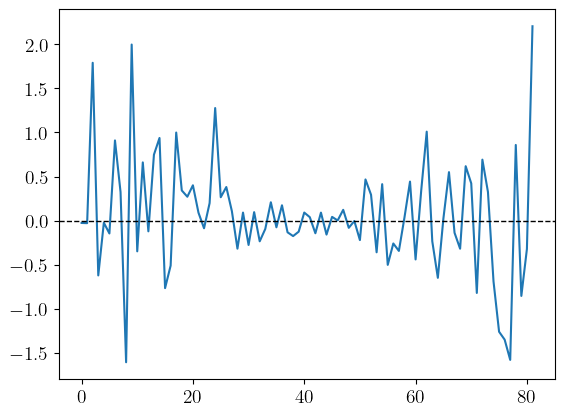

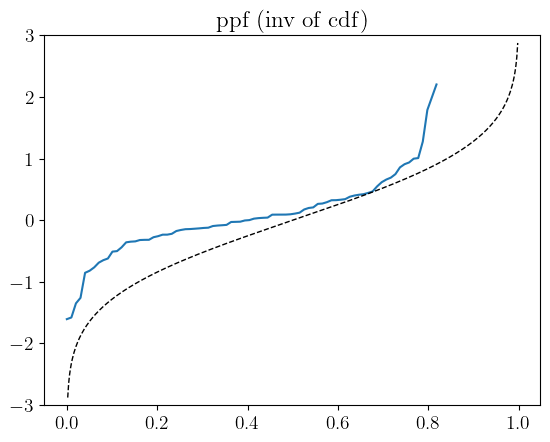

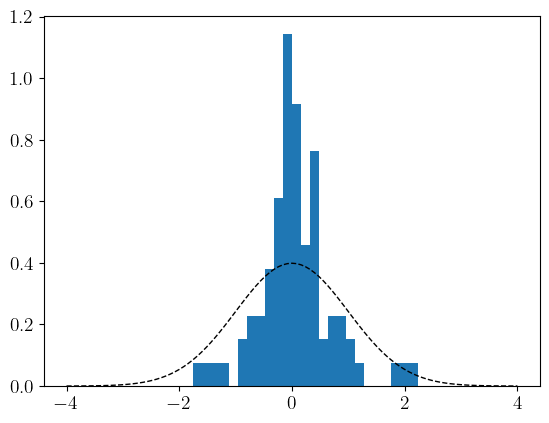

In [97]:
CC = test2.cov_mat
evals, evecs = np.linalg.eig(CC)
sorted_indexes = np.argsort(evals)[::-1]
evals = evals[sorted_indexes]
evecs = np.matrix(evecs[:,sorted_indexes])
print(evals)

# evecs.H @ CC @ evecs
i = 7

diag_ob = np.squeeze(np.asarray(evecs.H @ data2[i].ob)) / sqrt(evals)
aa = np.sum(diag_ob**2)
print(aa)
print(f"Variance: {np.var(diag_ob)}")
plt.plot((diag_ob))
plt.axhline(y=0, linestyle='--', linewidth=1, color='k')
# plt.ylim(-0.2,0.2)
plt.show()

plt.plot(np.linspace(0,1, dat_num), np.sort(diag_ob))
x_list = np.linspace(0,1, 501)
y_list = [norm.ppf(x) for x in x_list]
plt.plot(x_list, y_list, linestyle='--', linewidth=1, color='k')
plt.ylim(-3,3)
plt.title("ppf (inv of cdf)")
plt.show()

plt.hist(diag_ob[:], range=[-4,4], bins=50, density=True)
x_list = np.linspace(-4, 4, 101)
y_list = [norm.pdf(x) for x in x_list]
plt.plot(x_list, y_list, linestyle='--', linewidth=1, color='k')
plt.show()

# print(evals)
# for i in range(dat_num):
#     if i<10:
#         plt.plot(evecs[:,i])
#         plt.show()

In [206]:
m = 1e-13*eV / hbar
sig_v = 8e-4/sqrt(2)
v0_vec = np.array([0,0,8e-4])
T_coh = 2*pi/(m*sig_v**2)
dt = 0.0016*T_coh
t_data = np.array([0, dt])
x_data = np.array( [[0,0,AU/c], [0,0,AU/c]] )

test_num=1000
cov_simulate = np.zeros(test_num)

for i in tqdm(range(test_num)):
    sigs = DMRandomGenerator(t_data=t_data, x_data=x_data, seed=None, k_num=100000).ob
    cov_simulate[i] = sigs[0]*sigs[1]
avg = np.average(cov_simulate)

cov = Cov_mat_component(dt=dt, dx_vec=np.zeros(3), v_ob_vec = v0_vec, m=m, sig_v=sig_v, mpmath=False).real

print(avg)
print(cov)
print(cov_simulate[np.argmin(cov_simulate)])

plt.hist(cov_simulate, bins=50)
plt.axvline(x=cov, linestyle='--', linewidth=1, color='k')
plt.axvline(x=avg, linestyle='--', linewidth=1, color='b')
plt.show()

# Coherent wave vector distribution

In [135]:
v_num = 1000
sig_v = 8e-4/sqrt(2)

v_vecs = np.random.normal(0, sig_v, (v_num, 3)) + np.array( [0,0, 8e-4] )
r_vec = np.array( [0, sin(pi/3), cos(pi/3)] ) * AU/c



(1000, 3)

In [224]:
def vf_vec(r_vec, v_vec):
    mp2 = mp.mp.clone()
    mp2.dps = 12

    mass = 1e-12*eV/hbar
    # stdev_ratio = self.stdev_ratio
    vel = 8e-4
    sig_v = vel/sqrt(2)

    # r_vec = np.array( [rx, ry, rz] )
    v_dm = np.array( [0,0,8e-4] )
    # v_vec = v_dm + np.random.normal(0, vel*stdev_ratio, 3)

    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)

    M = mass
    B = M_sN*M / v
    Y = M * (v*r - np.inner(v_vec, r_vec))

    hyp0 = mp2.hyp1f1( 1j*B , 1 , 1j*Y )
    hyp1 = mp2.hyp1f1( 1+1j*B , 2 , 1j*Y )
    hyp0 = float(hyp0.real) + 1j*float(hyp0.imag)
    hyp1 = float(hyp1.real) + 1j*float(hyp1.imag)
    hyp_ratio = hyp1 / hyp0

    grad_phase = M*v_vec + np.angle( 1 - M*B*(v*r_vec/r - v_vec)*hyp_ratio )
    vf_vec = grad_phase / M

    return vf_vec

@ray.remote
def temp(t):

    v_num = 10000
    v_list = []
    vf_list = []

    angle = t / ly * 2*pi

    r_vec = np.array( [sin(angle), cos(angle)*sin(pi/3), cos(angle)*cos(pi/3) ] )
    v_dm = np.array( [0,0,8e-4] )
    sig_v = 8e-4/sqrt(2)

    v_list = v_dm + np.random.normal(0, sig_v, (v_num, 3))

    for i in (range(v_num)):
        v_vec = v_list[i]
        vf = vf_vec(r_vec, v_vec)
        vf_list.append(vf)

    vf_list = np.stack(vf_list, axis=0)
    return v_list, vf_list



# for i in range(1):
#     v_list, vf_list = temp()
#     v_lists.append(v_list)
#     vf_lists.append(vf_list)

t_num = 11
t_list = np.linspace(0, 0.5*ly, t_num)

v_dic={}
vf_dic={}

for k in tqdm(range(t_num)):
    t = t_list[k]
    v_lists = []
    vf_lists = []
    result_refs = []
    for i in range(12):
        test = temp.remote(t)
        result_refs.append(test)

    while result_refs:
        done, result_refs = ray.wait(result_refs)
        result = ray.get(done[0])
        v_lists.append(result[0])
        vf_lists.append(result[1])

    v_lists = np.concatenate(v_lists, axis=0)
    vf_lists = np.concatenate(vf_lists, axis=0 )

    v_dic[k] = v_lists
    vf_dic[k] = vf_lists

100%|██████████| 11/11 [02:04<00:00, 11.30s/it]


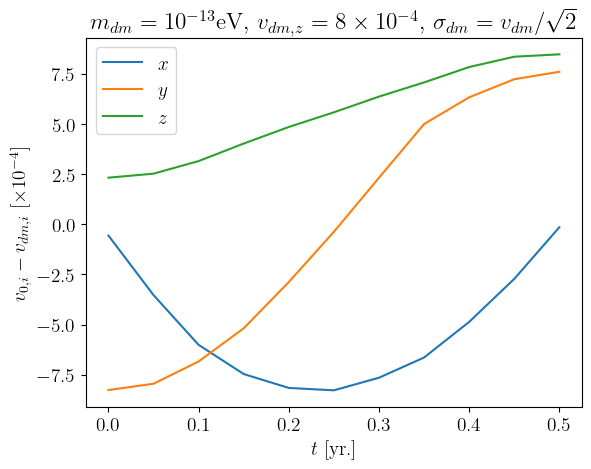

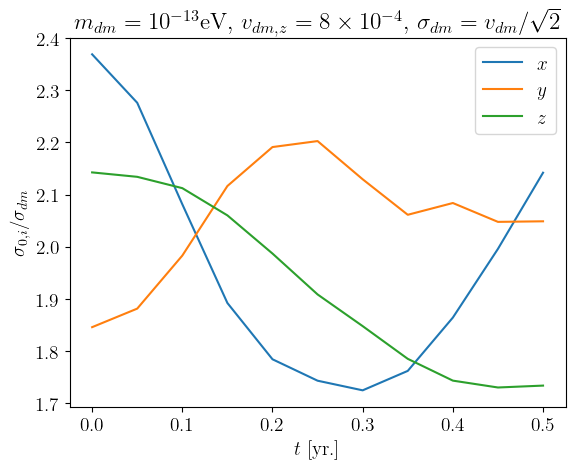

In [225]:
vf_avgs = []
vf_stds = []

for t_idx in range(t_num):
    vf_avgs.append( np.average(vf_dic[t_idx], axis=0) )
    vf_stds.append( np.var(vf_dic[t_idx], axis=0)**0.5 )

vf_avgs = np.stack(vf_avgs, axis=1)
vf_stds = np.stack(vf_stds, axis=1)

t_list = np.linspace(0,0.5, t_num)

plt.plot(t_list, vf_avgs[0]*1e4, label="$x$")
plt.plot(t_list, vf_avgs[1]*1e4, label="$y$")
plt.plot(t_list, (vf_avgs[2] - 8e-4)*1e4, label="$z$")
plt.xlabel("$t$ [yr.]")
plt.ylabel("$v_{0,i} - v_{dm,i}$ [$\\times10^{-4}$]")
plt.legend()
plt.title("$m_{dm}=10^{-13}$eV, $v_{dm,z}=8\\times10^{-4}$, $\\sigma_{dm} = v_{dm}/\\sqrt{2}$")
# plt.savefig("result/coh_v_avg.png", dpi=200, bbox_inches='tight')
plt.show()

sig_v = 8e-4/sqrt(2)

plt.plot(t_list, vf_stds[0] / sig_v, label="$x$")
plt.plot(t_list, vf_stds[1] / sig_v, label="$y$")
plt.plot(t_list, vf_stds[2] / sig_v, label="$z$")
plt.xlabel("$t$ [yr.]")
plt.ylabel("$\\sigma_{0,i} / \\sigma_{dm}$")
plt.legend()
plt.title("$m_{dm}=10^{-13}$eV, $v_{dm,z}=8\\times10^{-4}$, $\\sigma_{dm} = v_{dm}/\\sqrt{2}$")
# plt.savefig("result/coh_v_std.png", dpi=200, bbox_inches='tight')
plt.show()
